In [12]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
#%matplotlib 

In [114]:
# imagen en escala de grises
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)

# Función

- Se plantean los mismos parámetros vistos en clase
- Se define un kernell gaussiano de tamaño k_size, en este caso es 15
- debido que la función getGaussianKernel devuelve un vector de k_size filas y una columna, se multiplica por su transpuesta para general un kernell de dimension de k_size * k_size.
- Debido a que el kernell muy seguramente no va a tener la misma medida de de la img h x w, se realiza un padding con la función np.pad, para hallar cuando padding va en h y cuando va en w, se calcula (h - k_size) / 2 y (w - k_size) / 2, como h y w se manejan con solo enteros, cuando sea impar la división resultara con decimal .5, para esto utilizamos la función np.ceil para redondear al numero de arriba.
- se asignan 4 condiciones para indicar como realizar el padding cuando h o w son impares. esto para evitar que no se pueda realizar la multiplicación de el filtro espectral y la imagen por diferencia en su tamaño.

In [99]:
def create_gauss_filter(h, w, k_size=15, sigma=3):
    kernel = cv.getGaussianKernel(k_size, sigma)
    
    #Se debe transponer el filtro 
    kernel = kernel * kernel.T
    pad_h = int(np.ceil((h - k_size) / 2))
    pad_w = int(np.ceil((w - k_size) / 2))

    if ((h - k_size) % 2 != 0) & (((w - k_size) % 2) != 0):
        padded_kernel = np.pad(kernel, [(pad_h, pad_h-1), (pad_w, pad_w-1)], mode='constant')
    elif((h - k_size) % 2 == 0) & (((w - k_size) % 2) != 0):
        padded_kernel = np.pad(kernel, [(pad_h, pad_h), (pad_w, pad_w-1)], mode='constant')
    elif((h - k_size) % 2 != 0) & (((w - k_size) % 2) == 0):
        padded_kernel = np.pad(kernel, [(pad_h, pad_h-1), (pad_w, pad_w)], mode='constant')
    else:
        padded_kernel = np.pad(kernel, [(pad_h, pad_h), (pad_w, pad_w)], mode='constant')
        
    filter_f = np.fft.fft2(padded_kernel)
    #filter_f_shift = np.fft.fftshift(filter_f)
    filter_spatial = np.real(np.fft.ifft2(filter_f))
    return filter_spatial, filter_f

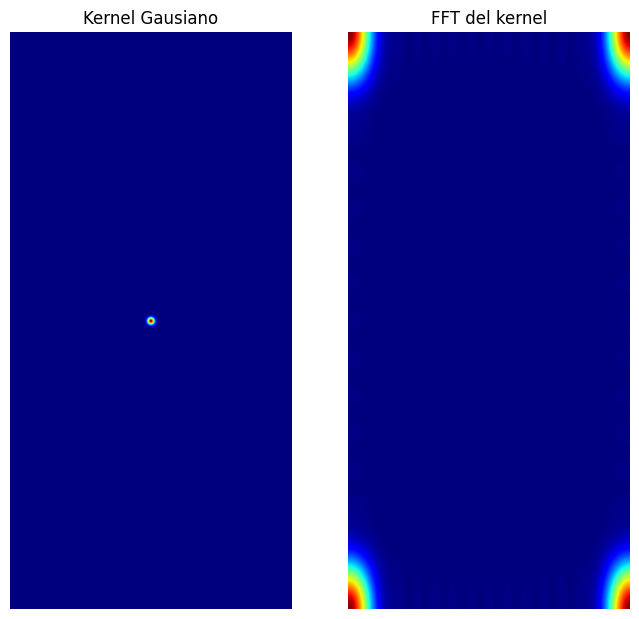

In [104]:
h, w = img.shape
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

Text(0.5, 1.0, 'Desenfoque gausiano')

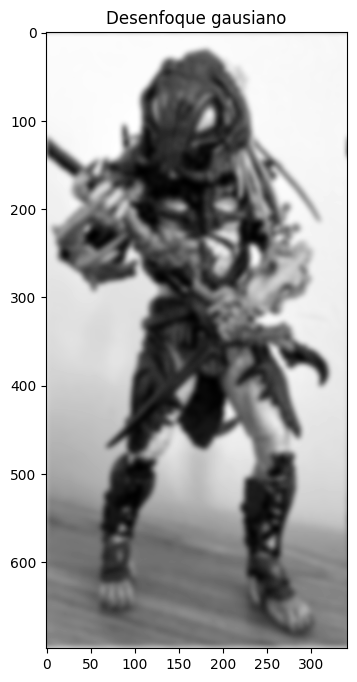

In [103]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

#img_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

# Algoritmo de medición de Calidad de Imagen

- Se aplican cada uno de los pasos indicados en el paper los cuales son mencionados entre el código

## Comparativa de imagenes

- se utiliza la imagen con filtrado espectral resultande de la función create_gauss_filter() para medir su calidad, y se utiliza la función cv.GaussianBlur() para generar un filtro gaussiano por convolución sobre la imagen Original, igualmente se mide su calidad. dando un mejor resultado la imagen de filtrado espectral

In [107]:
def im_qty_measure(img):
    
    # Step 1: Compute F which is the Fourier Transform representation of image I
    F = np.fft.fft2(img)
    
    # Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    Fc = np.fft.fftshift(F)
    
    # Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    af = np.abs(Fc)
    
    # Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(af)
    
    # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    thres = M/1000
    Th = np.sum(af > thres)
    
    # Step 6: Calculate Image Quality measure (FM) from equation (1)
    FM = Th / (img.shape[0]*img.shape[1]*M)
    
    return FM

In [113]:
#Fm imagen de filtrado espectral
print("Puntaje FM algortmo: ",im_qty_measure(img_gauss))

Puntaje FM algortmo:  3.6779424457541483e-10


In [112]:
#FM filtrado por convolución
img_conv = cv.GaussianBlur(img, ksize=(15, 15), sigmaX=5)
print("Puntaje FM algortmo: ",im_qty_measure(img_conv))

Puntaje FM algortmo:  2.9467720400500793e-10
